In [1]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import joblib

from catboost import CatBoostClassifier
from catboost import Pool, cv


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import recall_score
from sklearn.decomposition import PCA

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [45]:
df = pd.read_csv("/content/gdrive/MyDrive/pet-transformator/base_pred_to_clf_trans.csv")
X = df.drop("label", axis = 1).copy()
y = df["label"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
train_pool = Pool(data=x_train, label=y_train)
eval_pool = Pool(data=x_test, label=y_test)
print(df.shape)
print(x_train.shape)

(2100, 53)
(1680, 52)


# CatBoost из коробки

In [ ]:
cat = CatBoostClassifier(random_state=1, task_type='GPU')
cat.fit(x_train, y_train)
display(cat.score(x_train, y_train))

In [ ]:
print(classification_report(y_test, cat.predict(x_test)))

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       341
           2       0.93      0.78      0.85        18
           3       0.94      0.74      0.83        23
           4       0.78      0.76      0.77        38

    accuracy                           0.95       420
   macro avg       0.91      0.82      0.86       420
weighted avg       0.95      0.95      0.95       420



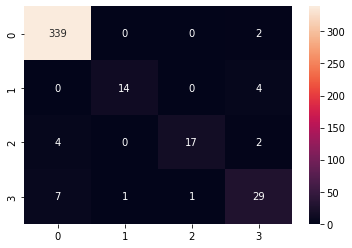

In [ ]:
sns.heatmap(confusion_matrix(y_test,cat.predict(x_test)), annot=True, fmt="1")

# **GridSearch all features**

In [ ]:
help(CatBoostClassifier)

In [ ]:
cat2 = CatBoostClassifier(iterations=2000, eval_metric = 'Accuracy',  
                          task_type='GPU', random_state=1, od_wait = 150,
                          gpu_ram_part = 0.95, verbose=True)
learning_rate = [0.3, 0.5, 0.7, 0.9, 1]
depth = [4, 5, 6, 7, 8, 9, 10]
l2_leaf_reg = [1, 3, 5, 7, 9, 12]               
param_dist = {'learning_rate': learning_rate,
               'depth': depth,
               'l2_leaf_reg': l2_leaf_reg,
}
grid_search_result = cat2.grid_search(param_dist,
                                                   X=x_train,
                                                   y=y_train,
                                                   cv=3,
                                                   stratified=True,
                                                   verbose=True)

In [ ]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 1}

In [ ]:
print(classification_report(y_test, cat2.predict(x_test)))

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       341
           2       0.88      0.78      0.82        18
           3       0.95      0.78      0.86        23
           4       0.81      0.76      0.78        38

    accuracy                           0.95       420
   macro avg       0.90      0.83      0.86       420
weighted avg       0.95      0.95      0.95       420



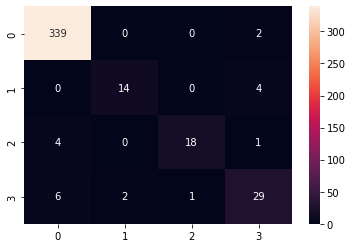

In [ ]:
sns.heatmap(confusion_matrix(y_test,cat2.predict(x_test)), annot=True, fmt="1")

Гиперпараметрическая настройка принесла незначительные улучшения в метриках.

По матрице ошибок видно, что настройка немного уменьшила количество ложных срабатываний.

In [ ]:
cat2.save_model('/content/gdrive/MyDrive/pet-transformator/Tuned_Cat_clf_allf.cbm',
           format="cbm")

In [8]:
cat2 = CatBoostClassifier().load_model('/content/gdrive/MyDrive/pet-transformator/Tuned_Cat_clf_allf.cbm')

In [ ]:
cat2.get_params()

{'depth': 4,
 'eval_metric': 'Accuracy',
 'gpu_ram_part': 0.95,
 'iterations': 2000,
 'l2_leaf_reg': 9,
 'learning_rate': 1,
 'loss_function': 'MultiClass',
 'od_wait': 150,
 'random_seed': 1,
 'task_type': 'GPU',
 'verbose': 0}

# **Feature selection**

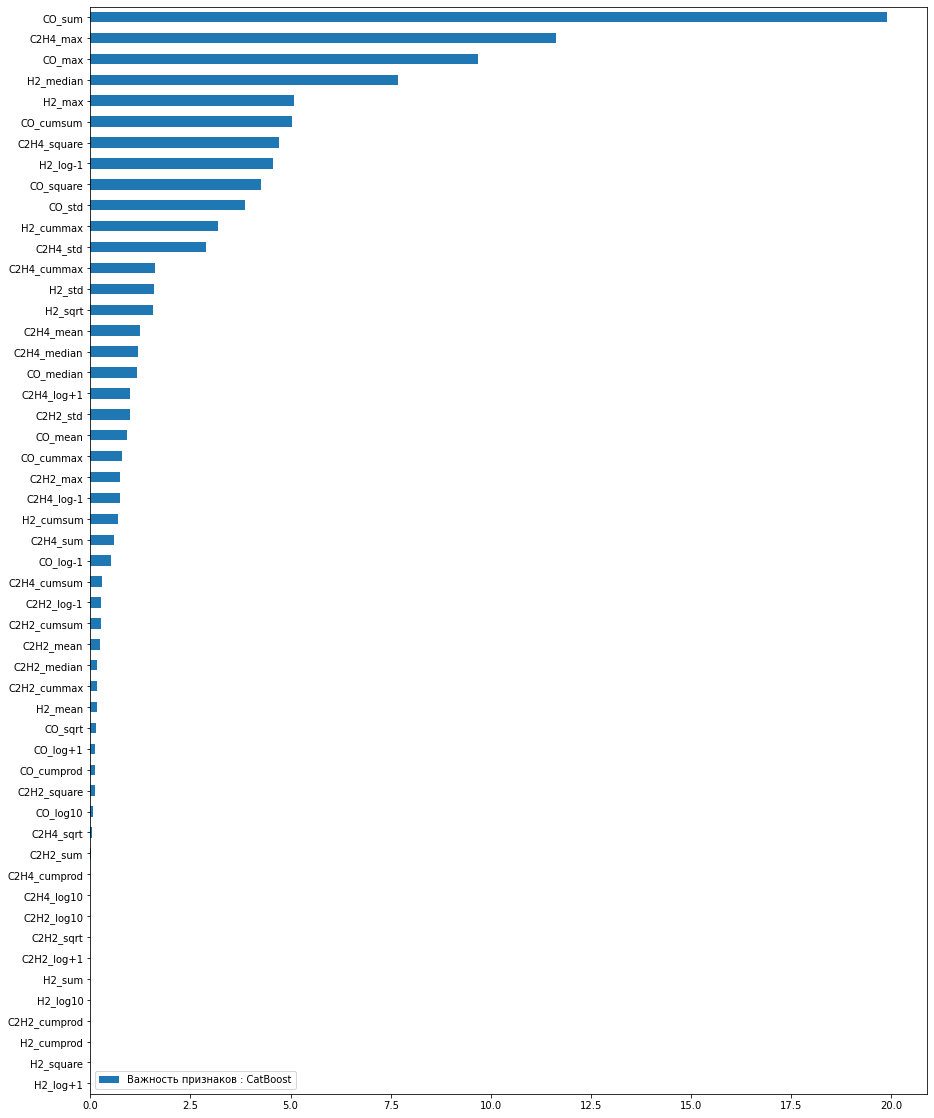

In [46]:
feature_importances_cat2 = cat2.feature_importances_
feature_importances_cat2Df = pd.DataFrame(feature_importances_cat2,
                                            index=df.drop('label', axis=1).columns,
                                            columns = ['Важность признаков : CatBoost']).sort_values('Важность признаков : CatBoost',ascending=True)
feature_importances_cat2Df.plot.barh(figsize=(15,20))

In [47]:
first_ignored_list = list(feature_importances_cat2Df[feature_importances_cat2Df['Важность признаков : CatBoost'] < 0.1].index)
first_ignored_index_list = [df.columns.get_loc(c) for c in first_ignored_list if c in df]
print(first_ignored_index_list)
print(len(first_ignored_list))

[20, 48, 32, 35, 40, 36, 23, 47, 43, 42, 34, 39, 46, 41]
14


## **1.1) 14 features ignored with `cat.select_features`**



In [ ]:
first_selection = cat2.select_features(
    train_pool,
    eval_set=eval_pool,
    features_for_select='0-51',
    num_features_to_select=38,
    steps=5,
    train_final_model=False,
    verbose=True)

In [51]:
cat2_params = cat2.get_params()
f_14_ignored_names_list = first_selection['eliminated_features']
print(f_14_ignored_names_list)
print(len(f_14_ignored_names_list))

[9, 44, 49, 25, 19, 2, 33, 41, 31, 26, 39, 14, 42, 10]
14


In [ ]:
cat3 = CatBoostClassifier().set_params(**cat2_params)
cat3.set_params(ignored_features=f_14_ignored_names_list)
learning_rate = [0.3, 0.5, 0.7, 0.9, 1]
depth = [4, 6, 8, 10]
l2_leaf_reg = [1, 3, 5, 7, 9, 12]               
param_dist = {'learning_rate': learning_rate,
               'depth': depth,
               'l2_leaf_reg': l2_leaf_reg,
}
grid_search_result = cat3.grid_search(param_dist,
                                                   X=x_train,
                                                   y=y_train,
                                                   cv=3,
                                                   stratified=True,
                                                   verbose=True)

In [ ]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 1}

In [ ]:
print(classification_report(y_test, cat3.predict(x_test)))

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       341
           2       0.93      0.78      0.85        18
           3       0.95      0.78      0.86        23
           4       0.79      0.79      0.79        38

    accuracy                           0.95       420
   macro avg       0.91      0.84      0.87       420
weighted avg       0.95      0.95      0.95       420



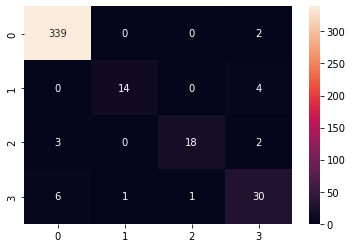

In [ ]:
sns.heatmap(confusion_matrix(y_test,cat3.predict(x_test)), annot=True, fmt="1")

Отсеяв 14 неиспользуемых признаков немного улучшили модель, убрав лишний шум, вносимый этими признаками.

Уменьшили ложные срабатывания модели. 

In [ ]:
cat3.save_model('/content/gdrive/MyDrive/pet-transformator/Tuned_Cat_clf_38f_with_select_feature(cat3).cbm',
           format="cbm")

In [52]:
cat3 = CatBoostClassifier().load_model('/content/gdrive/MyDrive/pet-transformator/Tuned_Cat_clf_38f_with_select_feature(cat3).cbm')

## **1.2) 14 features ignored with plot_importance**



In [ ]:
cat4 = CatBoostClassifier().set_params(**cat2_params)
cat4.set_params(ignored_features=first_ignored_index_list, od_wait=70)

learning_rate = [0.3, 0.5, 0.7, 0.9, 1]
depth = [3,4,5]
l2_leaf_reg = [1, 3, 5, 7, 9, 12]               
param_dist = {'learning_rate': learning_rate,
               'depth': depth,
               'l2_leaf_reg': l2_leaf_reg,
}
grid_search_result = cat4.grid_search(param_dist,
                                                   X=x_train,
                                                   y=y_train,
                                                   cv=3,
                                                   stratified=True,
                                                   verbose=True)

In [19]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 1}

In [20]:
print(classification_report(y_test, cat4.predict(x_test)))

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       341
           2       0.88      0.78      0.82        18
           3       0.95      0.78      0.86        23
           4       0.81      0.76      0.78        38

    accuracy                           0.95       420
   macro avg       0.90      0.83      0.86       420
weighted avg       0.95      0.95      0.95       420



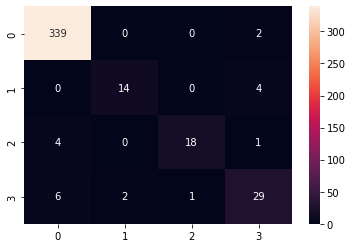

In [21]:
sns.heatmap(confusion_matrix(y_test,cat4.predict(x_test)), annot=True, fmt="1")

Сравнив метрики и матрицы ошибок в моделях, в которых исключены 14 признаков разными методами, делаем вывод, что `cat.select_features` работает эффективнее, чем ручной отбор признаков по важности.

In [22]:
cat4.save_model('/content/gdrive/MyDrive/pet-transformator/Tuned_Cat_clf_38f_with_plot_importance(cat4).cbm',
           format="cbm")

In [53]:
cat3.get_feature_importance(train_pool)

array([2.00990139e-01, 6.80542082e+00, 0.00000000e+00, 1.04382724e+00,
       4.30556873e+00, 1.36904745e+00, 9.76233332e-01, 3.61776896e-01,
       2.21487426e-01, 0.00000000e+00, 0.00000000e+00, 4.25179440e-01,
       2.25492294e+00, 2.77868664e+00, 0.00000000e+00, 2.09692721e+00,
       4.77543922e+00, 1.36958519e+01, 1.24434684e+01, 0.00000000e+00,
       1.44791143e-01, 6.48855583e-01, 3.22549253e-01, 2.69447411e-02,
       9.94421974e+00, 0.00000000e+00, 0.00000000e+00, 2.79126537e-01,
       2.15684588e+00, 7.62773515e-01, 3.48313576e+00, 0.00000000e+00,
       7.14346957e-04, 0.00000000e+00, 6.39039662e-01, 0.00000000e+00,
       0.00000000e+00, 1.68218661e+01, 1.56215991e+00, 0.00000000e+00,
       6.46855357e-05, 0.00000000e+00, 0.00000000e+00, 4.51849981e+00,
       0.00000000e+00, 1.99766504e-01, 5.02540703e-03, 8.35800699e-01,
       1.20711182e-06, 0.00000000e+00, 3.88336471e+00, 9.62707421e-03])

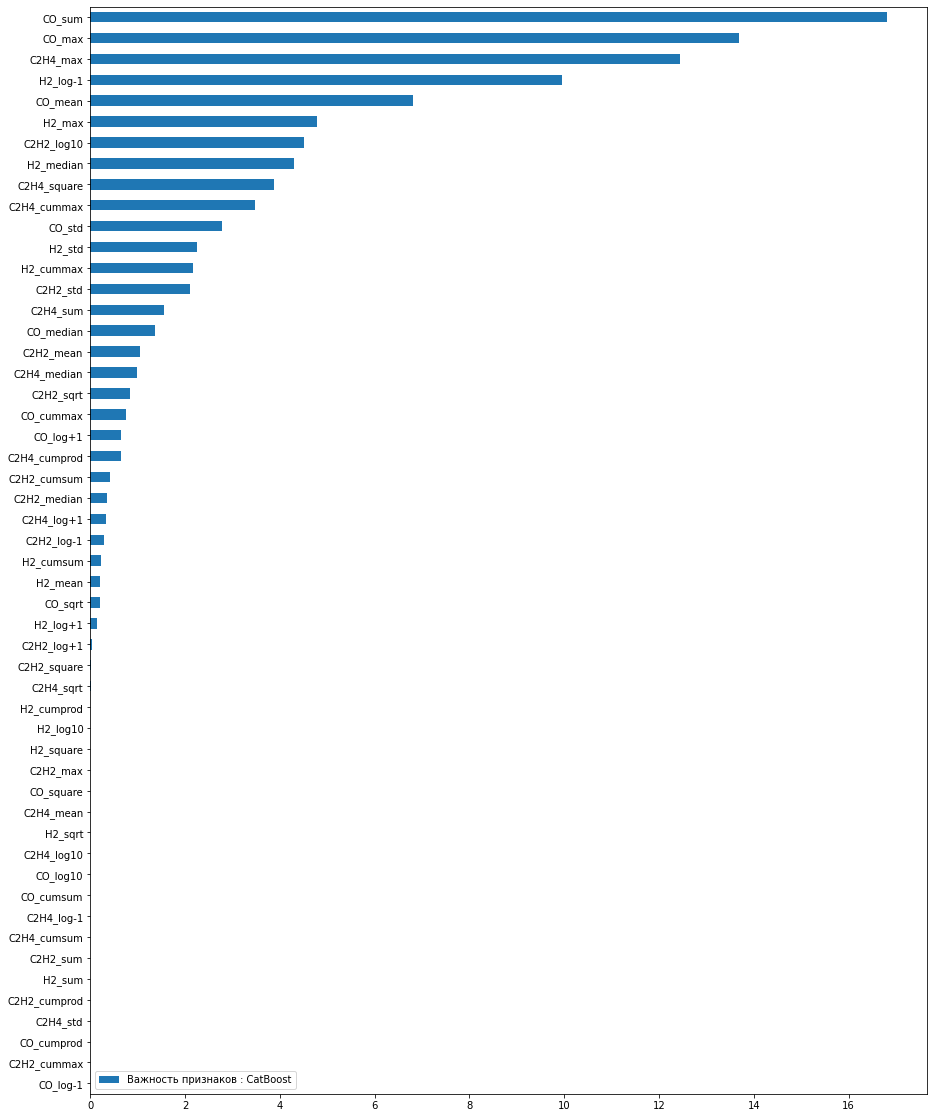

In [58]:
feature_importances_cat3 = cat3.feature_importances_
feature_importances_cat3Df = pd.DataFrame(feature_importances_cat3,
                                            index=df.drop('label', axis=1).columns,
                                            columns = ['Важность признаков : CatBoost']).sort_values('Важность признаков : CatBoost',ascending=True)
feature_importances_cat3Df.plot.barh(figsize=(15,20))

In [59]:
feature_importances_cat3Df

,Важность признаков : CatBoost
CO_log-1,0.000000
C2H2_cummax,0.000000
CO_cumprod,0.000000
C2H4_std,0.000000
C2H2_cumprod,0.000000
H2_sum,0.000000
C2H2_sum,0.000000
C2H4_cumsum,0.000000
C2H4_log-1,0.000000
CO_cumsum,0.000000


In [66]:
second_ignored_list = list(feature_importances_cat3Df[feature_importances_cat3Df['Важность признаков : CatBoost'] < 0.14].index)
len(second_ignored_list)

22

In [ ]:
second_selection = cat3.select_features(
    train_pool,
    eval_set=eval_pool,
    features_for_select='0-51',
    num_features_to_select=30,
    steps=10,
    train_final_model=False,
    verbose=True)

In [69]:
f_22_ignored_names_list = second_selection['eliminated_features']
len(f_22_ignored_names_list)

22

In [ ]:
cat5 = CatBoostClassifier().set_params(**cat2_params)
cat5.set_params(ignored_features=f_22_ignored_names_list, od_wait=70)

learning_rate = [0.7, 0.9, 1]
depth = [3,4,5]
l2_leaf_reg = [5, 7, 9, 12]               
param_dist = {'learning_rate': learning_rate,
               'depth': depth,
               'l2_leaf_reg': l2_leaf_reg,
}
grid_search_result = cat5.grid_search(param_dist,
                                                   X=x_train,
                                                   y=y_train,
                                                   cv=3,
                                                   stratified=True,
                                                   verbose=True)

In [71]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 1}

In [72]:
print(classification_report(y_test, cat5.predict(x_test)))

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       341
           2       0.82      0.78      0.80        18
           3       0.90      0.78      0.84        23
           4       0.77      0.71      0.74        38

    accuracy                           0.95       420
   macro avg       0.87      0.82      0.84       420
weighted avg       0.94      0.95      0.94       420



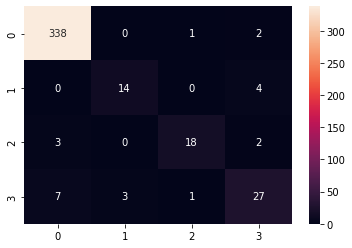

In [73]:
sns.heatmap(confusion_matrix(y_test,cat5.predict(x_test)), annot=True, fmt="1")

При исключении 22 признаков видим ухудшение работы модели.




Для дальнейшей работы используем модель, настроенную на всех признаках, и с исключенными 14 признаками.


In [82]:
cat2.save_model('/content/gdrive/MyDrive/pet-transformator/Tuned_Cat_clf_allf(Best1).cbm',
           format="cbm")
cat3.save_model('/content/gdrive/MyDrive/pet-transformator/Tuned_Cat_clf_38f_with_select_feature(Best2).cbm',
           format="cbm")

In [ ]:
cat6 = CatBoostClassifier().set_params(**cat2_params)
cat6.set_params(od_wait=70)
learning_rate = [0.92, 0.94, 0.96, 0.98, 1]
depth = [4]
l2_leaf_reg = [8, 8.5, 9, 9.5, 10, 10.5, 11]               
param_dist = {'learning_rate': learning_rate,
               'depth': depth,
               'l2_leaf_reg': l2_leaf_reg,
}
grid_search_result = cat6.grid_search(param_dist,
                                                   X=x_train,
                                                   y=y_train,
                                                   cv=10,
                                                   stratified=True,
                                                   verbose=True)

In [75]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 1}

In [76]:
print(classification_report(y_test, cat6.predict(x_test)))

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       341
           2       0.88      0.78      0.82        18
           3       0.95      0.78      0.86        23
           4       0.81      0.76      0.78        38

    accuracy                           0.95       420
   macro avg       0.90      0.83      0.86       420
weighted avg       0.95      0.95      0.95       420



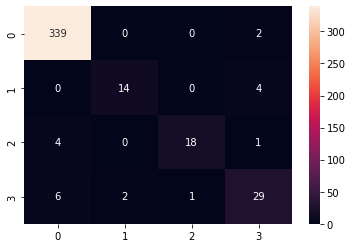

In [77]:
sns.heatmap(confusion_matrix(y_test,cat6.predict(x_test)), annot=True, fmt="1")

In [ ]:
cat7 = CatBoostClassifier().set_params(**cat2_params)
cat7.set_params(ignored_features=f_14_ignored_names_list, od_wait=70)

learning_rate = [0.92, 0.94, 0.96, 0.98, 1]
depth = [4]
l2_leaf_reg = [8, 8.5, 9, 9.5, 10, 10.5, 11]               
param_dist = {'learning_rate': learning_rate,
               'depth': depth,
               'l2_leaf_reg': l2_leaf_reg,
}
grid_search_result = cat7.grid_search(param_dist,
                                                   X=x_train,
                                                   y=y_train,
                                                   cv=10,
                                                   stratified=True,
                                                   verbose=True)

In [79]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 1}

In [80]:
print(classification_report(y_test, cat7.predict(x_test)))

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       341
           2       0.93      0.78      0.85        18
           3       0.95      0.78      0.86        23
           4       0.79      0.79      0.79        38

    accuracy                           0.95       420
   macro avg       0.91      0.84      0.87       420
weighted avg       0.95      0.95      0.95       420



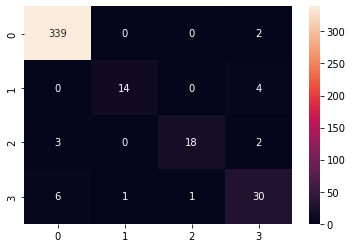

In [81]:
sns.heatmap(confusion_matrix(y_test,cat7.predict(x_test)), annot=True, fmt="1")